# Reddit Classification

In this project, we seek to use web scraping and NLP techniques to develop models to predict the classification of a post's subreddit.

For this project, we wil be looking at two subreddits:

[AskSience](https://www.reddit.com/r/askscience/): This subreddit consists of users asking questions and getting answers from subject matter experts. The topics cover Physics, Astronomy, Chemistry, Medicine, Psychology, Sociology, Political Science, Economics, Computing, Mathematics and many more.

[AskHistorians](https://www.reddit.com/r/AskHistorians/): This subreddit is where users can post questions or have discussions about History. It is one of the largest history forums on the Internet.

### Outline

* [Section 1: Problem Definition](#sec_1)
* [Section 2: Data Gathering](#sec_2)
* [Section 3: Data Exploration and Cleaning](#sec_3)
* [Section 4: Modelling the Data](#sec_4)
* [Section 5: Evaluation of Models and Parameters](#sec_5)
    * 5.1 Choosing a Vectorizer
    * 5.2 Logistic Regression
    * 5.3 Naive Bayes
    * 5.4 K Nearest Neighbors
* [Section 6: Findings](#sec_6)

## <a name="sec_1"></a>Section 1: Problem Definition

We look to explore classification models within the realm of natureal language processing (NLP).

The problem we are seeking to answer is whether or not we can build a classfication model to accurately predict if a post belongs to one subreddit or the other. Should we be able to, we take a closer look at which model(s) serves this purpose the best and why.

The stakeholders for this problem are the respective subreddit mods. This also extends beyond reddit to other forums and websites. We are looking to help these people to easily fish out posts which users have posted to the wrong subreddit and allow them to direct these users to the alternate subreddit where they can get access to the intended audience.

Success of our model will depend on the accuracy scores from each model which will be done on 'unseen' data via a train-test split of the dataset. We can use accuracy in this case over other metrics such as sensitivity or specificity as there are no better/ worse implications for type 1 or type 2 errors. Assuming we assin the value of 1 for askscience, a false positive would be a post that is classified as belonging to ask science when it actually belongs to AskHistorians. A false negative would be an askscience post that has been classified to belonging to AskHistorians. We can think of these as inverse to each other and of equal severity and as such, accuracy will be a good metric to score our models.

The motivation behind understanding which models work and what parameters work the best is that we can scale the models to fit different scenarios/ datasets if needed.

## <a name="sec_2"></a>Section 2: Data Gathering

We have scraped data from the 2 subreddits in a seperate notebook with the following fields of data:
* Subreddit
* Name
* Title
* Selftext
* Score

In total, we have approximately **1000 unique posts per subreddit**. We have ensured that the posts were not repeated in the other notebook.

In [1]:
# We read in the data from our saved files
import pandas as pd
hist = pd.read_csv('./data/askhistorians.csv')
science = pd.read_csv('./data/askscience.csv')

In [2]:
# We look at the data from the AskHistorians subreddit
hist.head()

,Unnamed: 0,subreddit,name,title,selftext,score
0,0,AskHistorians,t3_nyvt8e,Sunday Digest | Interesting &amp; Overlooked P...,[Previous](https://www.reddit.com/r/AskHistori...,28
1,1,AskHistorians,t3_nvvd8w,"Short Answers to Simple Questions | June 09, 2021",[Previous weeks!](https://www.reddit.com/r/Ask...,29
2,2,AskHistorians,t3_o0dn7y,"In fairy tales, there is a popular trope of be...",NaN,3061
3,3,AskHistorians,t3_o0w9hv,"In the Middle Ages, were merchants allowed to ...",The author describes a wool merchant chopping ...,40
4,4,AskHistorians,t3_o0ts67,Did English nobility get involved in the lives...,I’m watching Downton Abby for the first time. ...,60


In [3]:
# We then look at the data from the askscience subreddit
science.head()

,Unnamed: 0,subreddit,name,title,selftext,score
0,0,askscience,t3_l4yi0i,AskScience Panel of Scientists XXIV,**Please read this entire post carefully and f...,267
1,1,askscience,t3_o0bncs,AskScience AMA Series: We have 60+ years of ex...,"""We"" are part of [REN21](https://www.ren21.net...",748
2,2,askscience,t3_o0i9s0,How deep can water be before the water at the ...,Let's assume the water is pure H20 (and not se...,4230
3,3,askscience,t3_nzy81l,"If Hailey’s comet loses ice to form its tail, ...",NaN,5201
4,4,askscience,t3_o0k1fs,Why are liquids almost always shiny/reflective?,I am painting some furniture and just started ...,109


In [4]:
# We take a look at the shape of the datasets
print(f'The shape of the AskHistorians dataset is {hist.shape}.')
print(f'The shape of the askscience dataset is {science.shape}.')

The shape of the AskHistorians dataset is (999, 6).
The shape of the askscience dataset is (1000, 6).


## <a name="sec_3"></a>Section 3: Data Exploration and Cleaning

In this section, we look to clean the data before passing it through our models. The things we will be focused on include:
* Removing hyperlinks
* Removing HTML characters
* Converting words to lowercase
* Removing stopwords
* Lemmatizing the words

In [5]:
# We import what we need first

import pandas as pd
import requests
import time
import random
import string
import scipy.stats as stats
import numpy as np
import math 

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
from sklearn.metrics import plot_roc_curve
%matplotlib inline

# NLP
import nltk
from nltk.stem import WordNetLemmatizer
import regex as re
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords

# modelling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [6]:
# Combine the 2 dataframes
df = pd.concat([science,hist])

In [7]:
# Check the shape
df.shape

(1999, 6)

In [8]:
# Look at the data
df.head()

,Unnamed: 0,subreddit,name,title,selftext,score
0,0,askscience,t3_l4yi0i,AskScience Panel of Scientists XXIV,**Please read this entire post carefully and f...,267
1,1,askscience,t3_o0bncs,AskScience AMA Series: We have 60+ years of ex...,"""We"" are part of [REN21](https://www.ren21.net...",748
2,2,askscience,t3_o0i9s0,How deep can water be before the water at the ...,Let's assume the water is pure H20 (and not se...,4230
3,3,askscience,t3_nzy81l,"If Hailey’s comet loses ice to form its tail, ...",NaN,5201
4,4,askscience,t3_o0k1fs,Why are liquids almost always shiny/reflective?,I am painting some furniture and just started ...,109


In [9]:
# Drop the first column
df.drop(columns = ['Unnamed: 0'], inplace=True)

In [10]:
# We shuffle and reset the index for good measure such that the posts from each subreddit are mixed up.
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [11]:
# We need to do 2 more things, first fillna for subtext
df = df.fillna('')
hist = hist.fillna('')
science = science.fillna('')

In [12]:
# Then we combine the 2 title and selftext columns into a new column
df['title_selftext'] = df['title'] + df['selftext']
hist['title_selftext'] = hist['title'] + hist['selftext']
science['title_selftext'] = science['title'] + science['selftext']

In [13]:
# We then change the subreddit column to binary, 1 for askscience and 0 otherwise (askhistorians)
df['subreddit'] = df['subreddit'].map({'AskHistorians': 0, 'askscience': 1})

In [14]:
# We look at our dataset again
df.head()

,subreddit,name,title,selftext,score,title_selftext
0,1,t3_noxkki,What impact does climate have on transmission ...,"More specifically, COVID-19. Does the virus sp...",10,What impact does climate have on transmission ...
1,1,t3_nkb2wu,Roughly how many virion are released when an i...,I don't expect a precise answer and expect it ...,18,Roughly how many virion are released when an i...
2,1,t3_nlqw0c,Why can I see my LED lightbulbs flicker when I...,,4483,Why can I see my LED lightbulbs flicker when I...
3,1,t3_na09q4,Why does ocean-life have issues with microplas...,If microplastic and sand particles are roughly...,31,Why does ocean-life have issues with microplas...
4,0,t3_nzayn9,Andrew Jackson ran on a populist platform and ...,,10,Andrew Jackson ran on a populist platform and ...


In [15]:
# Before we proceed to clean text, we define our stopwords, we will be using NLTK's stopwords as a base
# We add in some additional stop words that relate to each subreddit
stops = stopwords.words('english')
add_sw = ['askscience', 'askhistorians', 'science', 'sciences', 'scientiests', 'history', 'historians', 'ask']
stops.extend(add_sw)

In [16]:
# create a function to clean text

# We first create a list of stopwords

wnl = WordNetLemmatizer()

def clean_text(text):
    
    # We first remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text) 
    
    # Remove HTML
    text = BeautifulSoup(text).get_text()
    
    # Remove non-letters
    text = re.sub("[^a-zA-Z]", ' ', text)
    
    # Convert to lower case and split into a list of words
    words = text.lower().split()
    
    # Set stopwords
    stop_words = set(stops)
    
    # Remove stopwords
    meaningful_words = [w for w in words if w not in stop_words]
    
    # We lemmatize the words
    lem_words = []
    for word in meaningful_words:
        word_lemmed = wnl.lemmatize(word)
        lem_words.append(word_lemmed)
        
    # Return joined words as a string
    seperator = ' '
    return(seperator.join(lem_words))
    

Note: We chose to lemmatize the words in our function above as history and science are topics with words that can be quite technical. There are likely to be variations of the same word as well. Stemming might not be the best choice here as we might have to deal with more variables than needed.

In [17]:
# Then we clean the text
df['title_selftext'] = df['title_selftext'].apply(clean_text)
hist['title_selftext'] = hist['title_selftext'].apply(clean_text)
science['title_selftext'] = science['title_selftext'].apply(clean_text)

In [18]:
# We look at the dataframe again and we ensure we can see all the data
pd.set_option('display.max_colwidth', None)
df.head()

,subreddit,name,title,selftext,score,title_selftext
0,1,t3_noxkki,What impact does climate have on transmission of virus/bacteria?,"More specifically, COVID-19. Does the virus spread at a higher rate in certain climates?",10,impact climate transmission virus bacteria specifically covid virus spread higher rate certain climate
1,1,t3_nkb2wu,Roughly how many virion are released when an infected cell ruptures?,I don't expect a precise answer and expect it varies with virus and cell type but I really have no idea what order of magnitude range is plausible.,18,roughly many virion released infected cell rupture expect precise answer expect varies virus cell type really idea order magnitude range plausible
2,1,t3_nlqw0c,"Why can I see my LED lightbulbs flicker when I see them in my periphery, but not directly?",,4483,see led lightbulb flicker see periphery directly
3,1,t3_na09q4,"Why does ocean-life have issues with microplastic particles, but not sand particles?","If microplastic and sand particles are roughly the same size, why isn't there more issues with sand in sea creatures as there is with microplastic?",31,ocean life issue microplastic particle sand particle microplastic sand particle roughly size issue sand sea creature microplastic
4,0,t3_nzayn9,Andrew Jackson ran on a populist platform and promised to help the regular people of America. Did he get much done that substantially improved the lives of the on-elite?,,10,andrew jackson ran populist platform promised help regular people america get much done substantially improved life elite


We can now compare the title, selftext and title_selftext columns.
Our code worked, we do not see any uppercase, special characters or links in our data. Common stopwords also have been removed, for example, 'What' in row index 0.

However, we should still check to see if there are any frequently occuring words in both subreddits which we have missed out in our stopwrods. These words, should they be generic, not specific to either subreddit and occur frequently in both should be dropped as well.

In [19]:
# We first create a copy of our data from the first round of cleaning
df_cleaned_once = df.copy()

In [20]:
# We run a simple test to see if there are any interesting words that show up frequently for each data set
cvec = CountVectorizer()
cvec.fit(hist['title_selftext'])
print(f'There are a total of {len(cvec.get_feature_names())} unique words')
                              
hist_cvec = pd.DataFrame(cvec.transform(hist['title_selftext']).todense(),columns=cvec.get_feature_names())
top_words_hist = hist_cvec.sum(axis=0)

top_words_hist_df = top_words_hist.to_frame(name='count')

top_words_hist_df['word'] = top_words_hist_df.index
top_words_hist_df.reset_index(drop=True, inplace=True)

cols = ['word','count']
top_words_hist_df = top_words_hist_df[cols]
top_words_hist_df.sort_values(by='count',ascending=False, inplace=True)

There are a total of 8619 unique words


In [21]:
# We run a simple test to see if there are any interesting words that show up for each data set
cvec = CountVectorizer()
cvec.fit(science['title_selftext'])
print(f'There are a total of {len(cvec.get_feature_names())} unique words')
                              
science_cvec = pd.DataFrame(cvec.transform(science['title_selftext']).todense(),columns=cvec.get_feature_names())
top_words_science = science_cvec.sum(axis=0)

top_words_science_df = top_words_science.to_frame(name='count')

top_words_science_df['word'] = top_words_science_df.index
top_words_science_df.reset_index(drop=True, inplace=True)

cols = ['word','count']
top_words_science_df = top_words_science_df[cols]
top_words_science_df.sort_values(by='count',ascending=False, inplace=True)

There are a total of 6950 unique words


In [22]:
# We reassign the top 20 words to new dataframes
top20_words_science = top_words_science_df.head(20)
top20_words_hist = top_words_hist_df.head(20)

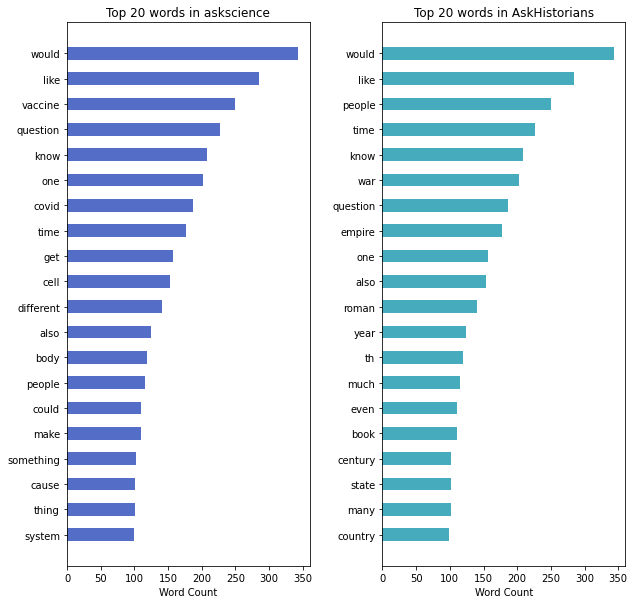

In [23]:
# We plot the counts of the top 20 words for each subreddit

fig, axes = plt.subplots(ncols=2, figsize=(10,10))
plt.subplots_adjust(wspace=.3)
axes[0].barh(top20_words_science['word'], top20_words_science['count'], .5, color='#294AB9', 
             alpha=0.8)
axes[0].invert_yaxis()
axes[0].set_title("Top 20 words in askscience", 
                  fontsize=12)
axes[0].set_xlabel("Word Count")
axes[1].barh(top20_words_hist['word'], top20_words_science['count'], .5, color='#1896ac', 
             alpha=0.8)
axes[1].invert_yaxis()
axes[1].set_title("Top 20 words in AskHistorians", 
                  fontsize=12)
axes[1].set_xlabel("Word Count");

We can clearly see that there are indeed some words which we missed out. Very clearly, we see words like 'would' and 'like' that have been missed. We plot the overlapping words in a venn diagram for better clarity.

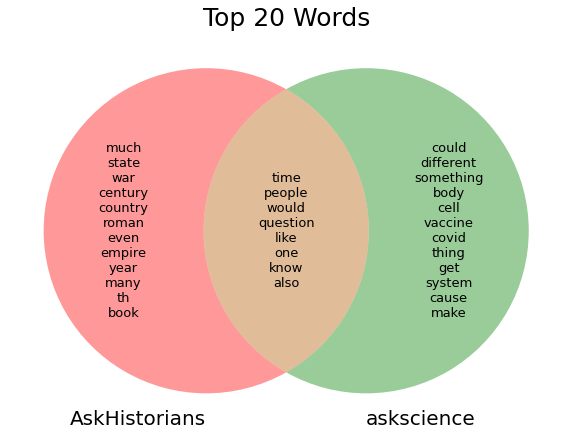

In [24]:
# We then plot the words in a venn diagram to look at the top words

plt.figure(figsize=(10,10))
plt.title('Top 20 Words',fontsize=25)

set_a = set(top_words_hist_df['word'][:20])
set_b = set(top_words_science_df['word'][:20])

venn = venn2([set_a,set_b],set_labels=['AskHistorians','askscience'])

venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)
venn.get_label_by_id('100').set_size(13)
venn.get_label_by_id('110').set_size(13)
venn.get_label_by_id('010').set_size(13)

We can see a list of words that are pretty generic and appear heavily in both subreddits, we remove these from our data.

In [25]:
# we then add in additional stopwords
add_sw_2 = ['people', 'also', 'one', 'know', 'like', 'would', 'question', 'time']
stops.extend(add_sw_2)

In [26]:
# We clean the text again
df['title_selftext'] = df['title_selftext'].apply(clean_text)
hist['title_selftext'] = hist['title_selftext'].apply(clean_text)
science['title_selftext'] = science['title_selftext'].apply(clean_text)

We now have a clean dataset and can proceed to explore the various models.

We should also be aware of the fact that simple sorting and cleaning will not help our classification problem. There is simply too much text and understanding domain-specific knowledge across multiple topics in Science and History is needed for us to make sense of our data at this point. The next course of action will be to model the data.

## <a name="sec_4"></a>Section 4: Modelling the Data

Now that we have a clean set of words to work with, we proceed to fit the data into models. We will be performing a train-test split on our data before fitting.

In this section, we look to explore the following models, both with countvectorizer and TF-IDF vectorizer:
* Logistic Regression
* Naive Bayes
* K Nearest Neighbors
* Decision Trees

Our goal for this section is to find the specific model(s) and parameters that produce good results on our test set. The metric we will be using for assessment is accuracy. As mentioned in the introduction, this is an apt metric to use here. 

A good model in this case would not only mean a good accuracy score on the test data, we should also be mindful of overfitting and achieving a healthy balance between bias and variance.

We will be using pipelines and append our results to a table for comparison.

In [27]:
# Perform train test split first
X = df['title_selftext']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify = y,
                                                    random_state = 42)

In [28]:
# Check y values
y.value_counts(normalize=True)

1    0.50025
0    0.49975
Name: subreddit, dtype: float64

Our baseline accuracy score will be 0.50025 given that it is the majority class. However, this isn't very useful as we will definitely be able to beat it with a simple model.

Before we start modelling the data, let us take a closer look at the words in X_train. This will help us navigate working with pipelines and the appropriate params later on instead of starting completely blind.

Let us first look at the word counts.

Shape of X_train_cvec: (1500, 10572)


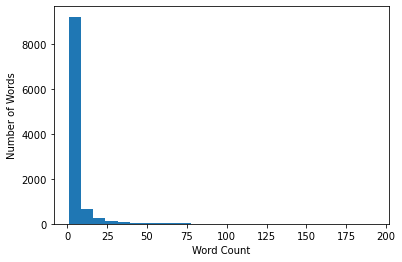

In [29]:
# We will do a simple countvectorizer first
cvec = CountVectorizer()
X_train_cvec = cvec.fit_transform(X_train)
X_train_cvec_df = pd.DataFrame(X_train_cvec.toarray(),
                          columns=cvec.get_feature_names())


X_train_cvec_df.loc['Total']= X_train_cvec_df.sum()

total_word_count = X_train_cvec_df.loc['Total']

# Plot out the histogram of word counts
plt.hist(x=total_word_count, bins = 25);
plt.ylabel('Number of Words')
plt.xlabel('Word Count');

print(f'Shape of X_train_cvec: {X_train_cvec_df.shape}')

We can see that the majority of words appear between 0 - 10 times. There is also no word that appears more than 200 times. What this tells us is that when we vectorize our data, gridsearching over max_df is rather pointless as we know that our data is relatively clean and there is no one word that is appearing in majority of our observations. Just as a precaution, we will max_df to 0.9.

We list out the exact numbers below to see how many words just appear once.


In [30]:
X_train_cvec_df_t = X_train_cvec_df.T
X_train_cvec_df_t['Total'].value_counts()

1      5022
2      1706
3       870
4       534
5       392
       ... 
108       1
116       1
180       1
77        1
135       1
Name: Total, Length: 128, dtype: int64

In [31]:
# We look to get more clarity on the count of words too

mean = X_train_cvec_df_t['Total'].mean()
mode = X_train_cvec_df_t['Total'].mode()
max = X_train_cvec_df_t['Total'].max()

print(f'The mean number of counts per word is {mean}')
print(f'The mode of number of counts per word is {mode}')
print(f'The max number of counts per word is {max}')


The mean number of counts per word is 5.338157396897465
The mode of number of counts per word is 0    1
dtype: int64
The max number of counts per word is 192


We also know that the maximum number of words is 10,573 so we will not be needing to set max_features beyong that point. Given that the max number of word count is 192, we can also be comfortable in using our max_df of 0.8.

We see that 5022 words only occur once in the dataset, this is not an overwhelming amount and we can vary min_df to include 1.

We can now move on to fitting some models with appropriate params. For simplicity sake, we will be naming the respective gridsearches such that we can reference any one of them in the future.

### Models
|Model Name|Vectorizer|Model|
|---|---|---|
|**gs1**|Count Vectorizer|Logistic Regression|
|**gs2**|TF-IDF Vectorizer|Logistic Regression|
|**gs3**|Count Vectorizer|Naive Bayes|
|**gs4**|TF-IDF Vectorizer|Naive Bayes|
|**gs5**|Count Vectorizer|K Nearest Neighbors|
|**gs6**|TF-IDF Vectorizer|K Nearest Neighbors|
|**gs7**|Count Vectorizer|Decision Trees|
|**gs8**|TF-IDF Vectorizer|Decision Trees|

In [32]:
%%time
# This framework will be the one we use for our modelling
# We first work with a pipeline with Countvectorizer and Logistic Regression

print(f'CountVectorizer with Logistic Regression.')      # Prints out what model and vectorizer we are looking at

# Set up pipeline
lr_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(random_state=42))
])

# Set pipe params
lr_pipe_params = {
    'cvec__max_features': [4000,6000,8000],
    'cvec__min_df': [1, 2, 3, 4],
    'cvec__max_df': [0.9],
    'cvec__ngram_range': [(1, 1), (1, 2), (1,3)],
}

#Instantiate Gridsearch
gs1 = GridSearchCV(lr_pipe, 
                  param_grid=lr_pipe_params, 
                  cv=5) 

# Fit
gs1.fit(X_train, y_train)
gs1_model = gs1.best_estimator_

# See results
print(f'The best parameters are {gs1_model.steps}.')
print(f'The best score is {gs1.best_score_}')
print(f'The model score is {gs1_model.score(X_train, y_train)}')
print(f'The score for the test data is {gs1_model.score(X_test, y_test)}')

CountVectorizer with Logistic Regression.
The best parameters are [('cvec', CountVectorizer(max_df=0.9, max_features=6000, min_df=2, ngram_range=(1, 2))), ('lr', LogisticRegression(random_state=42))].
The best score is 0.919953177257525
The model score is 0.9993328885923949
The score for the test data is 0.922
Wall time: 1min 30s


In [33]:
%%time
# Next, with TF-IDF and Logistic Regression
print(f'TF-IDF Vectorizer with Logistic Regression.')

# Set up pipeline
lr_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(random_state=42))
])

# Set pipe params
lr_pipe_params = {
    'tvec__max_features': [4000,6000,8000],
    'tvec__min_df': [1, 2, 3, 4],
    'tvec__max_df': [0.9],
    'tvec__ngram_range': [(1, 1), (1, 2), (1,3)],
}

#Instantiate Gridsearch
gs2 = GridSearchCV(lr_pipe, 
                  param_grid=lr_pipe_params, 
                  cv=5) 

# Fit
gs2.fit(X_train, y_train)
gs2_model = gs2.best_estimator_

# See results
print(f'The best parameters are {gs2_model.steps}.')
print(f'The best score is {gs2.best_score_}')
print(f'The model score is {gs2_model.score(X_train, y_train)}')
print(f'The score for the test data is {gs2_model.score(X_test, y_test)}')

TF-IDF Vectorizer with Logistic Regression.
The best parameters are [('tvec', TfidfVectorizer(max_df=0.9, max_features=4000, min_df=2, ngram_range=(1, 3))), ('lr', LogisticRegression(random_state=42))].
The best score is 0.9339598662207358
The model score is 0.9893262174783188
The score for the test data is 0.928
Wall time: 1min 27s


Our logistic regression results look rather promising. The only thing to note is that the model score is close to 100, there might be some semblance of overfitting which we can explore later on.

In [34]:
%%time
# We move on to use CountVectorizer and Naive Bayes

print(f'CountVectorizer with Naive Bayes.')
# Set up pipeline
nb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

# Set pipe params
nb_pipe_params = {
    'cvec__max_features': [4000,6000,8000],
    'cvec__min_df': [1, 2, 3, 4],
    'cvec__max_df': [0.9],
    'cvec__ngram_range': [(1, 1), (1, 2), (1,3)],
}

#Instantiate Gridsearch
gs3 = GridSearchCV(nb_pipe, # what object are we optimizing?
                  param_grid=nb_pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

# Fit
gs3.fit(X_train, y_train)
gs3_model = gs3.best_estimator_

# See results
print(f'The best parameters are {gs3_model.steps}.')
print(f'The best score is {gs3.best_score_}')
print(f'The model score is {gs3_model.score(X_train, y_train)}')
print(f'The score for the test data is {gs3_model.score(X_test, y_test)}')

CountVectorizer with Naive Bayes.
The best parameters are [('cvec', CountVectorizer(max_df=0.9, max_features=6000, ngram_range=(1, 3))), ('nb', MultinomialNB())].
The best score is 0.9399643255295429
The model score is 0.981320880587058
The score for the test data is 0.93
Wall time: 1min 15s


In [35]:
%%time
# Next, with TF-IDF and Naive Bayes
print(f'TF-IDF Vectorizer with Naive Bayes.')

# Set up pipeline
nb_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Set pipe params
nb_pipe_params = {
    'tvec__max_features': [4000,6000,8000],
    'tvec__min_df': [1, 2, 3, 4],
    'tvec__max_df': [0.9],
    'tvec__ngram_range': [(1, 1), (1, 2), (1,3)],
}

#Instantiate Gridsearch
gs4 = GridSearchCV(nb_pipe, # what object are we optimizing?
                  param_grid=nb_pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

# Fit
gs4.fit(X_train, y_train)
gs4_model = gs4.best_estimator_

# See results
print(f'The best parameters are {gs4_model.steps}.')
print(f'The best score is {gs4.best_score_}')
print(f'The model score is {gs4_model.score(X_train, y_train)}')
print(f'The score for the test data is {gs4_model.score(X_test, y_test)}')

TF-IDF Vectorizer with Naive Bayes.
The best parameters are [('tvec', TfidfVectorizer(max_df=0.9, max_features=6000, ngram_range=(1, 3))), ('nb', MultinomialNB())].
The best score is 0.941964325529543
The model score is 0.989993328885924
The score for the test data is 0.934
Wall time: 1min 22s


In [36]:
%%time
# We move on to use CountVectorizer and KNN

print(f'CountVectorizer with KNN.')
# Set up pipeline
knn_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

# Set pipe params
knn_pipe_params = {
    'cvec__max_features': [4000,6000,8000],
    'cvec__min_df': [1, 2, 3, 4],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1, 1), (1, 2), (1,3)],
    'knn__n_neighbors': [5,10,20],
    'knn__metric': ['minkowski', 'euclidean', 'manhattan']
}

#Instantiate Gridsearch
gs5 = GridSearchCV(knn_pipe, # what object are we optimizing?
                  param_grid=knn_pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

# Fit
gs5.fit(X_train, y_train)
gs5_model = gs5.best_estimator_

# See results
print(f'The best parameters are {gs5_model.steps}.')
print(f'The best score is {gs5.best_score_}')
print(f'The model score is {gs5_model.score(X_train, y_train)}')
print(f'The score for the test data is {gs5_model.score(X_test, y_test)}')

CountVectorizer with KNN.
The best parameters are [('cvec', CountVectorizer(max_df=0.9, max_features=4000, min_df=4, ngram_range=(1, 2))), ('knn', KNeighborsClassifier())].
The best score is 0.7145061315496098
The model score is 0.8519012675116745
The score for the test data is 0.752
Wall time: 1h 38min 9s


In [37]:
%%time
# We move on to use TF-IDF Vectorizer and KNN

print(f'TF-IDF Vectorizer with KNN.')
# Set up pipeline
knn_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

# Set pipe params
knn_pipe_params = {
    'tvec__max_features': [4000,6000,8000],
    'tvec__min_df': [1, 2, 3, 4],
    'tvec__max_df': [0.9, 0.95],
    'tvec__ngram_range': [(1, 1), (1, 2), (1,3)],
    'knn__n_neighbors': [5,10,20],
    'knn__metric': ['minkowski', 'euclidean', 'manhattan']
}

#Instantiate Gridsearch
gs6 = GridSearchCV(knn_pipe, # what object are we optimizing?
                  param_grid=knn_pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

# Fit
gs6.fit(X_train, y_train)
gs6_model = gs6.best_estimator_

# See results
print(f'The best parameters are {gs6_model.steps}.')
print(f'The best score is {gs6.best_score_}')
print(f'The model score is {gs6_model.score(X_train, y_train)}')
print(f'The score for the test data is {gs6_model.score(X_test, y_test)}')

TF-IDF Vectorizer with KNN.
The best parameters are [('tvec', TfidfVectorizer(max_df=0.9, max_features=6000, min_df=2, ngram_range=(1, 3))), ('knn', KNeighborsClassifier(n_neighbors=20))].
The best score is 0.9226131549609811
The model score is 0.9359573048699132
The score for the test data is 0.91
Wall time: 13min 27s


In [38]:
%%time
# We move on to use CountVectorizer and Decision Trees

print(f'CountVectorizer with Decision Tree.')
# Set up pipeline
dt_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('dt', DecisionTreeClassifier())
])

# Set pipe params
dt_pipe_params = {
    'cvec__max_features': [2000,4000,6000],
    'cvec__min_df': [1, 2, 3, 4],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'dt__max_depth' : [2,3,4],
    'dt__min_samples_split': [10, 20],
    'dt__min_samples_leaf': [2, 4],
    'dt__ccp_alpha': [0, 0.01, 1]
}

#Instantiate Gridsearch
gs7 = GridSearchCV(dt_pipe, # what object are we optimizing?
                  param_grid=dt_pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

# Fit
gs7.fit(X_train, y_train)
gs7_model = gs7.best_estimator_

# See results
print(f'The best parameters are {gs7_model.steps}.')
print(f'The best score is {gs7.best_score_}')
print(f'The model score is {gs7_model.score(X_train, y_train)}')
print(f'The score for the test data is {gs7_model.score(X_test, y_test)}')

CountVectorizer with Decision Tree.
The best parameters are [('cvec', CountVectorizer(max_df=0.9, max_features=2000)), ('dt', DecisionTreeClassifier(ccp_alpha=0, max_depth=4, min_samples_leaf=2,
                       min_samples_split=10))].
The best score is 0.6537703455964325
The model score is 0.6537691794529686
The score for the test data is 0.604
Wall time: 1h 35min 40s


In [39]:
%%time
# We move on to use TF-IDF and Decision Trees

print(f'TF-IDF Vectorizer with Decision Tree.')
# Set up pipeline
dt_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('dt', DecisionTreeClassifier())
])

# Set pipe params
dt_pipe_params = {
    'tvec__max_features': [2000,4000,6000],
    'tvec__min_df': [1, 2, 3, 4],
    'tvec__max_df': [0.9, 0.95],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'dt__max_depth' : [2,3,4],
    'dt__min_samples_split': [10, 20],
    'dt__min_samples_leaf': [2, 4],
    'dt__ccp_alpha': [0, 0.01, 1]
}

#Instantiate Gridsearch
gs8 = GridSearchCV(dt_pipe, # what object are we optimizing?
                  param_grid=dt_pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

# Fit
gs8.fit(X_train, y_train)
gs8_model = gs8.best_estimator_

# See results
print(f'The best parameters are {gs8_model.steps}.')
print(f'The best score is {gs8.best_score_}')
print(f'The model score is {gs8_model.score(X_train, y_train)}')
print(f'The score for the test data is {gs8_model.score(X_test, y_test)}')

TF-IDF Vectorizer with Decision Tree.
The best parameters are [('tvec', TfidfVectorizer(max_df=0.9, max_features=2000)), ('dt', DecisionTreeClassifier(ccp_alpha=0, max_depth=4, min_samples_leaf=2,
                       min_samples_split=10))].
The best score is 0.6537703455964325
The model score is 0.6537691794529686
The score for the test data is 0.604
Wall time: 21min 9s


In [40]:
# We first create an empty dataframe to house our results
cols = ['Model Name', 'Model', 'Steps', 'Best_Score', 'Model_Score', 'Test_Score']
results = pd.DataFrame(columns=cols)

In [41]:
# We now append the results from our output to our results table
# We are interested in the params used, model score, train score and test score
gs_list = [gs1, gs2, gs3, gs4, gs5, gs6, gs7, gs8]

# gs5','gs6','gs7', 'gs8'

for v,i in enumerate(gs_list):
    x = {'Model Name':'gs' + str(v+1),
        'Model': str(i.best_estimator_[1]),
                        'Steps': str(i.best_params_),
                        'Best_Score': round(i.best_score_,4),
                        'Model_Score': round(i.best_estimator_.score(X_train, y_train),4),
                        'Test_Score': round(i.best_estimator_.score(X_test, y_test),4)
                        }
    results = results.append(x, ignore_index=True)
    

In [42]:
# We take a look at the results
results

,Model Name,Model,Steps,Best_Score,Model_Score,Test_Score
0,gs1,LogisticRegression(random_state=42),"{'cvec__max_df': 0.9, 'cvec__max_features': 6000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}",0.9200,0.9993,0.922
1,gs2,LogisticRegression(random_state=42),"{'tvec__max_df': 0.9, 'tvec__max_features': 4000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3)}",0.9340,0.9893,0.928
2,gs3,MultinomialNB(),"{'cvec__max_df': 0.9, 'cvec__max_features': 6000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 3)}",0.9400,0.9813,0.930
3,gs4,MultinomialNB(),"{'tvec__max_df': 0.9, 'tvec__max_features': 6000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 3)}",0.9420,0.9900,0.934
4,gs5,KNeighborsClassifier(),"{'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 4, 'cvec__ngram_range': (1, 2), 'knn__metric': 'minkowski', 'knn__n_neighbors': 5}",0.7145,0.8519,0.752
5,gs6,KNeighborsClassifier(n_neighbors=20),"{'knn__metric': 'minkowski', 'knn__n_neighbors': 20, 'tvec__max_df': 0.9, 'tvec__max_features': 6000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3)}",0.9226,0.9360,0.910
6,gs7,"DecisionTreeClassifier(ccp_alpha=0, max_depth=4, min_samples_leaf=2,\n min_samples_split=10)","{'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'dt__ccp_alpha': 0, 'dt__max_depth': 4, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 10}",0.6538,0.6538,0.604
7,gs8,"DecisionTreeClassifier(ccp_alpha=0, max_depth=4, min_samples_leaf=2,\n min_samples_split=10)","{'dt__ccp_alpha': 0, 'dt__max_depth': 4, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 10, 'tvec__max_df': 0.9, 'tvec__max_features': 2000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 1)}",0.6538,0.6538,0.604


We can see from the tbale that the Naive Bayes with TF-IDF vectorizer scored the highest on the test score. However, we also have to bear in mind the trade off between overfitting and accuracy with unseen data. We will create a new column to measure the difference between the train score and test score.

In [43]:
results['Overfitting'] = results['Model_Score'] - results['Test_Score']

In [44]:
results

,Model Name,Model,Steps,Best_Score,Model_Score,Test_Score,Overfitting
0,gs1,LogisticRegression(random_state=42),"{'cvec__max_df': 0.9, 'cvec__max_features': 6000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}",0.9200,0.9993,0.922,0.0773
1,gs2,LogisticRegression(random_state=42),"{'tvec__max_df': 0.9, 'tvec__max_features': 4000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3)}",0.9340,0.9893,0.928,0.0613
2,gs3,MultinomialNB(),"{'cvec__max_df': 0.9, 'cvec__max_features': 6000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 3)}",0.9400,0.9813,0.930,0.0513
3,gs4,MultinomialNB(),"{'tvec__max_df': 0.9, 'tvec__max_features': 6000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 3)}",0.9420,0.9900,0.934,0.0560
4,gs5,KNeighborsClassifier(),"{'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 4, 'cvec__ngram_range': (1, 2), 'knn__metric': 'minkowski', 'knn__n_neighbors': 5}",0.7145,0.8519,0.752,0.0999
5,gs6,KNeighborsClassifier(n_neighbors=20),"{'knn__metric': 'minkowski', 'knn__n_neighbors': 20, 'tvec__max_df': 0.9, 'tvec__max_features': 6000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3)}",0.9226,0.9360,0.910,0.0260
6,gs7,"DecisionTreeClassifier(ccp_alpha=0, max_depth=4, min_samples_leaf=2,\n min_samples_split=10)","{'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'dt__ccp_alpha': 0, 'dt__max_depth': 4, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 10}",0.6538,0.6538,0.604,0.0498
7,gs8,"DecisionTreeClassifier(ccp_alpha=0, max_depth=4, min_samples_leaf=2,\n min_samples_split=10)","{'dt__ccp_alpha': 0, 'dt__max_depth': 4, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 10, 'tvec__max_df': 0.9, 'tvec__max_features': 2000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 1)}",0.6538,0.6538,0.604,0.0498


We can eliminate the 2 decision tree models immediately given the low scores on both training and unseen data. We go on to select a few models for further examination. The 3 models that look the best are:
* **Logistic Regressoin with TF-IDF Vectorizer**: This model shows better results than the Logistic Regression with count vectorizer. We might want to examine overfitting of this model later on.
* **Naive Bayes with TF-IDF Vectorizer**: The Naive Bayes model performed well for both vectorizers but we will select the TF-IDF vectorizer given better test results.
* **K Nearest Neighbors with TF-IDF Vectorizer**: Even though this model didn't perform as well as the 2 above, it still gave decent results but more importantly, showed the smallest degree of overfitting.



## <a name="sec_5"></a>Section 5: Evaluation of Models and Parameters

In this seciton, We go on to fine tune these 3 models further to find the best parameters. This was done in the pipeline but we can do more below in a seamless manner.

After which, we will also look to intepret the output of each model and also look at the wrongly classified results.

### 5.1 Choosing a Vectorizer

First, we will take a look at the TF-IDF vectorizer. For all our models, we chose the TF-IDF vectorizer instead of the simple count vectorizer. We look further into the vectorizer to understand it.

<img src="./images/tfidf.png">

The formula for working out the TF-IDF value is shown above. 
Term frequency is the number of times a term appears in a document.
N refers to the total number of documents
Document frequency is the number of documents that have the specific term.

We model this out with 3 instances, our assumption is that there are 100 documents each with 10 words:
* A term that appears in 5 documents and appears once in each document
* A term that appears in 5 documents and appears 5 times in each document
* A term that appears in 50 documents and appears once
* A term that appears in 50 documents and appears 5 times in each document

In [47]:
# A term that appears in 5 documents and appears once in each document
print((1/10) * math.log(100/5))
# A term that appears in 5 documents and appears 5 times in each document
print((5/10) * math.log(100/5))
# A term that appears in 50 documents and appears once
print((1/10) * math.log(100/50))
# A term that appears in 50 documents and appears 5 times in each document
print((5/10) * math.log(100/50))

0.2995732273553991
1.4978661367769954
0.06931471805599453
0.34657359027997264


We can see that the log function is the inveerse document frequency. The more the number of documents have a certain term, the less weight it will have. This reduces the importance of words that occur too frequently in multiple documents.

The term frequency is directly correlated to the weight. The more times a word appears in a specific document, the higher its weight will be. 

This vectorizer works marginally better than the count vectorizer as it penalizes words that occur too often and helps us to 'scale' our data to amplify words that appear infrequently but have good predictive power. For example, if 1 of our test data from the history subreddit contains the word 'Umayyad', one of the largest dynasties in the past, we can be sure that if a new test post comes in containing the same word, the word 'Umayyad' will have a high impact on clasfficiation.

This is why the TF-IDF vectorizer was chosen over the count vectorizer. 

The next question we ask is, if the TF-IDF vectorizer is good at penalizing words that occur too frequently, will we still need to omit stopwords?

We model this out to find out.

In [48]:
# We first amend our text cleaning function to exclude stop words
wnl = WordNetLemmatizer()

def clean_text1(text):
    
    # We first remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text) 
    
    # Remove HTML
    text = BeautifulSoup(text).get_text()
    
    # Remove non-letters
    text = re.sub("[^a-zA-Z]", ' ', text)
    
    # Convert to lower case and split into a list of words
    words = text.lower().split()
    

    meaningful_words = [w for w in words]
    
    # We lemmatize the words
    lem_words = []
    for word in meaningful_words:
        word_lemmed = wnl.lemmatize(word)
        lem_words.append(word_lemmed)
        
    # Return joined words as a string
    seperator = ' '
    return(seperator.join(lem_words))

In [49]:
# We create a new df and clean it to not remove stop words
df1 = pd.concat([science,hist])
df1.drop(columns = ['Unnamed: 0'], inplace=True)
df1 = df1.sample(frac=1, random_state=42).reset_index(drop=True)
df1 = df1.fillna('')
df1['title_selftext'] = df1['title'] + df1['selftext']
df1['subreddit'] = df1['subreddit'].map({'AskHistorians': 0, 'askscience': 1})
df1['title_selftext'] = df1['title_selftext'].apply(clean_text1)

X1 = df1['title_selftext']
y1 = df1['subreddit']

# We train test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,
                                                    y1,
                                                    test_size = 0.25,
                                                    stratify = y,
                                                    random_state = 42)

# Perform simple log regression with TF_IDF
tvec = TfidfVectorizer(max_df = 0.9,
                      max_features = 7000,    # Anything beyond this number doesnt change
                      min_df = 2,
                      ngram_range = (1,2))

X1_train_tvec = tvec.fit_transform(X1_train)
X1_test_tvec = tvec.transform(X1_test)

lr = LogisticRegression(random_state=42)

lr.fit(X1_train_tvec, y1_train)

print(f'The model score (TF-IDF) is {lr.score(X1_train_tvec, y1_train)}')
print(f'The score (TF-IDF) for the test data is {lr.score(X1_test_tvec, y1_test)}')


# We do one with count vectoriser for comparison
cvec = CountVectorizer(max_df = 0.9,
                      max_features = 7000,    # Anything beyond this number doesnt change
                      min_df = 2,
                      ngram_range = (1,2))

X1_train_cvec = cvec.fit_transform(X1_train)
X1_test_cvec = cvec.transform(X1_test)

lr = LogisticRegression(random_state=42)

lr.fit(X1_train_cvec, y1_train)

print(f'The model score (Count Vec) is {lr.score(X1_train_cvec, y1_train)}')
print(f'The score (Count Vec) for the test data is {lr.score(X1_test_cvec, y1_test)}')

The model score (TF-IDF) is 0.9819879919946631
The score (TF-IDF) for the test data is 0.928
The model score (Count Vec) is 0.9993328885923949
The score (Count Vec) for the test data is 0.922


We can see that the results are not too bad and do not differ far from the results of our cleaned dataset which dropped stopwords. However, it is worse off. Another positive for removing stopwords is that we can easily read our data and omit words that occur frequently but do not hold any significant meaning. It is still a good practice to use stop words as our dataset might be biased as the style of writing for reddit users might be similar. Should we be comparing 2 groups of data from different domains, stopwords might come in handy. Overall, we still use TF-IDF vectorizer and stopwords.

Comparing to using count vectorizer, there is also less overfitting with TF-IDF and a better score as well, confirming our hypothesis.

### 5.2 Logistic Regression
We now move on to our first model which is logistic regression with TF-IDF vectorizer

In [50]:
# We first work with the Logistic Regression with TF-IDF Vectorizer
tvec = TfidfVectorizer(max_df = 0.9,
                      max_features = 7000,    # Anything beyond this number doesnt change
                      min_df = 2,
                      ngram_range = (1,2))

X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

lr = LogisticRegression(random_state=42)

lr.fit(X_train_tvec, y_train)

print(f'The model score is {lr.score(X_train_tvec, y_train)}')
print(f'The score for the test data is {lr.score(X_test_tvec, y_test)}')


The model score is 0.9913275517011341
The score for the test data is 0.936


After further tuning, we have the following observations:
* **max_df** This is an unimportant parameter for our dataset as we have removed the most common words (all of which are also irrelevant) and there is no word that appears more than 10% of the time. This is also assuming that our max_features does not reach a low number.
* **max_features** The sweet spot for this is around the 4,500 mark beyond which there is no improvement in our test score and below which, our scores deprove. However, this is done with the ngram range being (1,1). We can achieve the same results by setting ngram range to (1,2) and moving the max_features up to 7,000. The logic behind this is that with a (1,1) ngram, setting max_features low will effectively remove the words that occur the least frequently (words that appear once or twice and are unlikely to help). By setting ngram range to (1,2), words that occurred once in the previous iteration will be dropped too given that they are likely to appear once but just with a different connecting word.
* **min_df** Setting this to 2 gives us the best results as it also removes words that appear infrequently
* **ngram_range** The best param for this is (1,2) as both history and science are technical topics and some of the words should appear in pairs. My hypothesis is that these will be words such as 'Covid Vaccine' or 'World War' etc.

In [51]:
# We now look at the output of our logistic regression

# We first convert X_train_tvec to a dataframe
X_train_tvec_df = pd.DataFrame(X_train_tvec.toarray(),
                          columns=tvec.get_feature_names())

# We create a dataframe to house our results
lr_results = pd.DataFrame()

# We append our results to the dataframe
coeffs = []

for i in range(0,len(lr.coef_[0])):
    coeffs.append(lr.coef_[0][i])
    
    
lr_results['word'] = X_train_tvec_df.columns
lr_results['coefs'] = coeffs


# We sort the results
lr_results = lr_results.sort_values(by=['coefs'], ascending = False)

# We create a dataframe to house the top 10 words
top_words = pd.DataFrame()

top_words['top_science_lr'] = lr_results.head(10)['word'].tolist()
top_words['top_hist_lr'] = lr_results.tail(10)['word'].tolist()

In [52]:
top_words

,top_science_lr,top_hist_lr
0,vaccine,king
1,covid,army
2,cause,american
3,cell,th
4,earth,empire
5,water,german
6,virus,ancient
7,blood,book
8,plant,roman
9,brain,war


These are the top 10 words which contribute the most to predicting that a post belongs to the askscience subreddit. Most of the words we expect to see here. The most interesting one is the word 'cause'. This is an unlikely word to appear but after some consideration, this makes sense. Science is described by the [Cambridge Dictionary](https://dictionary.cambridge.org/dictionary/english/science) as the careful study of the structure and behaviour of the physical world, especially by watching, measuring, and doing experiments, and the development of theories to describe the results of these activities. A large part of science includes the understanding of causal activities and thus, this is why the word pops up and is useful in our model.

The second column shows the top terms you would expect to see in the AskHistorians subreddit. These are largely surrounding different civilisations and 'empires' - we see roman, american, german. An interesting one is the word 'th'. This could possibly be more another word lemmatized through our text cleaning earlier but after further exploring, it seems that words such as 'the', 'them' etc retain their form. This is most likley the result of us dropping numbers from phrases such as '17th century' which leaves behind 'th'.

In [53]:
# Look at misclassfied data

# Create a new dataframe
lr_preds = pd.DataFrame()

prob_1 = []
prob_0 = []

lr_preds['Actual'] = y_test
lr_preds['Predicted'] = lr.predict(X_test_tvec).tolist()
lr_preds['Predict_Proba'] = [i[1] for i in lr.predict_proba(X_test_tvec)]
lr_preds['Text'] = X_test
lr_preds['Correct'] = lr_preds['Actual'] - lr_preds['Predicted'] # If the value is 1, we misclassified a science post,
                                                                 # If the value is -1, we misclassified a hist post

# Look at number of misclassified posts
lr_preds['Correct'].value_counts()

 0    468
 1     18
-1     14
Name: Correct, dtype: int64

Overall, we misclassified more science posts (there were more science posts that we classified as hist).

We plot out our predictions to see this more clearly.

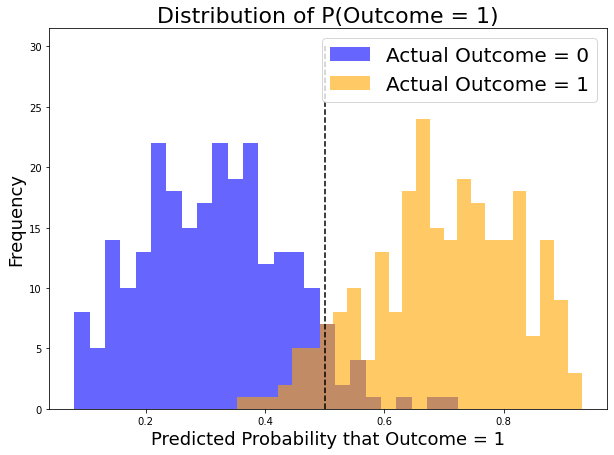

In [54]:
pred_df = pd.DataFrame({'true_values': lr_preds['Actual'],
                        'pred_probs':lr_preds['Predict_Proba']})
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Actual Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Actual Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
          ymin=0,
          ymax=30,
          color='black',
          linestyle = '--')


# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

With reference to the chart above:
* The blue area reflects AskHistorians Posts which were classified correctly
* The yellow area reflects askscience posts which were classified correctly
* The brown area reflects posts which were misclassified

We can clearly see that there is a larger brown area on the left side of the chart, indicating that there were more posts that were misclassified as AskHistorians.

A good thing about our model is that the misclassifications center around 0.5 and there are none at the tails of the graph. Another way to explain this is that our model did not misclassify a askscience post to a large degree and vice versa.

We go on to look at the misclassified posts and see if we can see any possible trends.

In [55]:
# Look at the misclassified science posts
lr_preds.loc[lr_preds['Correct'] == 1]

,Actual,Predicted,Predict_Proba,Text,Correct
940,1,0,0.493789,urethra sting sometimes urinate ejaculation,1
1827,1,0,0.439858,earth annular lake north th parallel earth land surface wikipedia list annular lake north th parallel follow three country canada finland sweden make country prone annular lake others account majority land north th,1
1964,1,0,0.452042,aquifer underground lake river title pretty much said always thought underground lake got thinking recently maybe river reading curious granite sand gravel aquifer regard,1
860,1,0,0.453569,manage diabetes modern medicine,1
1350,1,0,0.470503,classical music playing robot insult close ai replicating human performance research done topic good piano instrument playing ai,1
1818,1,0,0.487052,method exist target synthesis copernicium theorized island stability copernicium seems two isotope theorized island stability island stability derived zagrebaev svg predicted half life beyond year synthesized copernicium already go targeting synthesis specific isotope,1
244,1,0,0.465630,finer detail jincan poison recently learned jincan poison got googled say last survivor get eaten larva never specified larva specie jincan fatal symptom considering ancient chinese poison using wild life native south east china possible replicate method venomous arthropod animal used process,1
1311,1,0,0.469109,stop diverting river replenish aral sea something bugged aral sea since learned soviet understand water still used agriculture kazakstan uzbekistan devastation losing th largest lake world seem outweigh missing something global disruptive tech challenge restoring landscape aral sea region april none discussed even partially returning river,1
1138,1,0,0.425578,discover supervolcano yellowstone writing bit alternate find answer everywhere easily looked talk previous eruption happened want scientist discovered supervolcano yellowstone,1
272,1,0,0.493051,especially f orbitals show poor shielding effect guess somehow connected character electron find connection p orbitals good shielding effect f,1


We can see that most of the misclassified science posts contain semblance of geographical information (lakes, river, volcano, island, glacier etc.) It is likely that the same type of topics are discussed in AskHistorians when discussing empires and wars. There is no simple way to overcome this other than getting a larger volumn of training data. The good news is that there is no systemic error in our model for a specific kind of post that is getting constantly misclssified.

There are no clear outliers in the data as most of the probabilities lie around the 0.4 range.

We move on to look at AskHistorians posts that have been misclassified.

In [56]:
# Look at the misclassified hist posts
lr_preds.loc[lr_preds['Correct'] == -1]

,Actual,Predicted,Predict_Proba,Text,Correct
1994,0,1,0.556209,many doctor professional knew tuskeegee syphilis experiment dr irwin shatz read article medical journal wrote outraged letter study author big journal study published repeatedly edit running point whistleblower came forward degree common knowledge amongst medical professional edit schatz shatz,-1
1638,0,1,0.628940,happened mom produce enough milk formula formula mom enough milk wet nurse could pull milk various animal inquiring mom anywhere world,-1
942,0,1,0.532709,often lifeboat battleship cruiser compromised battle damage understand hit carrier far lifeboat around center deck well gunships close fight damaged enough deploy lifeboat lifeboat likely screwed,-1
1990,0,1,0.503034,singapore brunei interchangeable currency,-1
548,0,1,0.549163,limit number ranking qing dynasty harem sorry phrased poorly understanding qing dynasty harem certain ranking system starting empress highest going second class attendant limited amount spot ranking unlimited amount ranking,-1
110,0,1,0.538320,impact mass popular displacement partition language spoken immediate region language hindi urdu adopt lose vocabulary phrase,-1
729,0,1,0.688047,domestication deer widespread example reindeer range overlap northern human population deer specie exist almost environment human found besides providing good amount meat fur deer provide unique resource form antler course reindeer prove least certain specie capable draught animal give,-1
1793,0,1,0.512787,pricing become ubiquitous understand basic psychology saying easier person justify spending rather pricing scheme become commonplace particular person industry started trend,-1
188,0,1,0.722717,concerned revealing earth position golden record voyager space probe given probe low speed often context discussion voyager space probe mention elaborate golden record included craft show position earth potential alien specie finding probe often mention opposed inclusion security ground elaborate given low speed probe au sun year later light year au nearest star several light year sun think probe position trajectory alone likely make easy discern came alien specie advanced enough able visit u concern added later fringe group similar thought large hadron collider destroy universe turned genuine concern anyone taken seriously,-1
805,0,1,0.557640,much extinct celtiberian language could possibly revived,-1


We see that there are certain 'scientific terms' that show up in these posts but used in a different context, for example:
* milk **formula**
* **doctor** professional
* **medical** professional
* **interchangable** currency
* popular **displacement**

This is just a matter of our model not being able to contextualise some words which can be used in more than one circumstance. A possible improvement is to use other vectorizers that can account for this.

There is also one outlier in line 188 with probability score of 0.72. This is so as the text contains words such as 'alien', 'space', 'record', 'potential', 'sun', 'light', 'trajectory' and many more which are all closely related to science. There are much less history-related words in this post.

Another thing to note is that in both sets of misclassified data, there seem to be a number of very short posts. We go on to find the average number of words in each observation.

In [57]:
# Look at average number of words in title_selftext
word_count = []
for i in range(0, len(df['title_selftext'])):
    word_count.append(len(df['title_selftext'][i].split()))
    

# Find average number of words
sum(word_count)/len(word_count)

37.98749374687344

There are clearly many observations that have less than 38 words and thus this could have led to a lack of information and a higher chance of misclassification.

Overall, our logistic regression model with TF-IDF vectorizer is decent. It manages to accurately classify unseen data and misclasfficiations are mostly due to contextual errors and a lack of data for specific observations.

### 5.3 Naive Bayes
We move on now to Naive Bayes, our second model.

In [58]:
# Let us repeat the same steps with Naive Bayes with TF-IDF Vectorizer
tvec = TfidfVectorizer(max_df = 0.9,
                      max_features = 7000,    # Anything beyond this number doesnt change
                      min_df = 1,
                      ngram_range = (1,1))

X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

nb = MultinomialNB()

nb.fit(X_train_tvec, y_train)

print(f'The model score is {nb.score(X_train_tvec, y_train)}')
print(f'The score for the test data is {nb.score(X_test_tvec, y_test)}')


The model score is 0.9913275517011341
The score for the test data is 0.942


After further tuning, we have the following observations:
* **max_df** This is an unimportant parameter for our dataset as we have removed the most common words (all of which are also irrelevant) and there is no word that appears more than 10% of the time. This is also assuming that our max_features does not reach a low number.
* **max_features** The sweet spot for this is around the 7,000 and anything beyond this does not change results of our testing data
* **min_df** This can take either 1 or 2 and results do not differ. This is likely so as the vectorizer itself can tease out whether a word is important or not in relation to the total dataset.
* **ngram_range** The best param for this is (1,2) as both history and science are technical topics and some of the words should appear in pairs. My hypothesis is that these will be words such as 'Covid Vaccine' or 'World War' etc.

We move on to look at which words hold the most weight for our model.

In [59]:
# We first convert X_train_tvec to a dataframe
X_train_tvec_df = pd.DataFrame(X_train_tvec.toarray(),
                          columns=tvec.get_feature_names())

# We create a dataframe to house our results
nb_col = ['Word', 'Coefficient']
nb_results = pd.DataFrame(columns=nb_col)

# We append our results to the dataframe
coeffs = []

for i in range(0,len(nb.coef_[0])):
    coeffs.append(nb.coef_[0][i])
    
nb_results['Coefficient'] = coeffs

nb_results['Word'] = X_train_tvec_df.columns

# We sort the results
nb_results = nb_results.sort_values(by=['Coefficient'], ascending = False)

# We add the top words to our dataframe
top_words['top_science_nb'] = nb_results.head(10)['Word'].tolist()
top_words['top_hist_nb'] = nb_results.tail(10)['Word'].tolist()

top_words

C:\Users\gregw\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


,top_science_lr,top_hist_lr,top_science_nb,top_hist_nb
0,vaccine,king,vaccine,pride
1,covid,army,covid,priest
2,cause,american,cell,primal
3,cell,th,cause,prime
4,earth,empire,water,primogeniture
5,water,german,get,prince
6,virus,ancient,body,princeps
7,blood,book,different,principality
8,plant,roman,blood,principate
9,brain,war,difference,zulu


We can see that the top words for science is more or less the same. One thng interesting is that we see 'difference' and 'different' appear as well. This links back to our logic that for science topics, relationships between certain phenomenon is a common question to ask and thus, these words being significant. However, when we look at the top words for history, there is a vast difference. To understand this, we have to look at the difference between the Naive Bayes and Logistic Regression models.

Both models are classification models. Naïve Bayes is a classification method based on Bayes’ theorem that derives the probability of the given feature vector being associated with a label. Naïve Bayes has a naive assumption of conditional independence for every feature, which means that the algorithm expects the features to be independent which not always is the case.

Logistic regression is a linear classification method that learns the probability of a sample belonging to a certain class. Logistic regression tries to find the optimal decision boundary that best separates the classes.

The learning mechanism is a bit different between the two models, where Naive Bayes is a generative model and Logistic regression is a discriminative model.
Generative model: Naive Bayes models the joint distribution of the feature X and target Y, and then predicts the posterior probability given as P(y|x)
Discriminative model: Logistic regression directly models the posterior probability of P(y|x) by learning the input to output mapping by minimising the error.

Posterior probability can be defined as the probability of event A happening given that event B has occurred, in more layman terms this means that the previous belief can be updated when we have new information. 

Naïve Bayes assumes all the features to be conditionally independent. So, if some of the features are in fact dependent on each other (in case of a large feature space), the prediction might be poor.
Logistic regression splits feature space linearly, and typically works reasonably well even when some of the variables are correlated.

Given this, the output for logistic regression gives us more context and given that some words might be correlated to others, the top words for logistic regression are the ones that are the best predictors with the context of other words whereas for naive bayes, these are the words that give us the best predictors independently.


Source: [Comparison between Naive Bayes and Logistic Regression](https://dataespresso.com/en/2017/10/24/comparison-between-naive-bayes-and-logistic-regression/)

We not move on to look at the misclassified data.

In [60]:
# Look at misclassfied data

# Create a new dataframe
nb_preds = pd.DataFrame()

prob_1 = []
prob_0 = []

nb_preds['Actual'] = y_test
nb_preds['Predicted'] = nb.predict(X_test_tvec).tolist()
nb_preds['Predict_Proba'] = [i[1] for i in nb.predict_proba(X_test_tvec)]
nb_preds['Text'] = X_test
nb_preds['Correct'] = nb_preds['Actual'] - nb_preds['Predicted'] # If the value is 1, we misclassified a science post,
                                                                 # If the value is -1, we misclassified a hist post

# Look at number of misclassified posts
nb_preds['Correct'].value_counts()

 0    471
 1     18
-1     11
Name: Correct, dtype: int64

Overall, we see less misclassifications as compared to the logistic regression.

We plot it out to see where these lie.

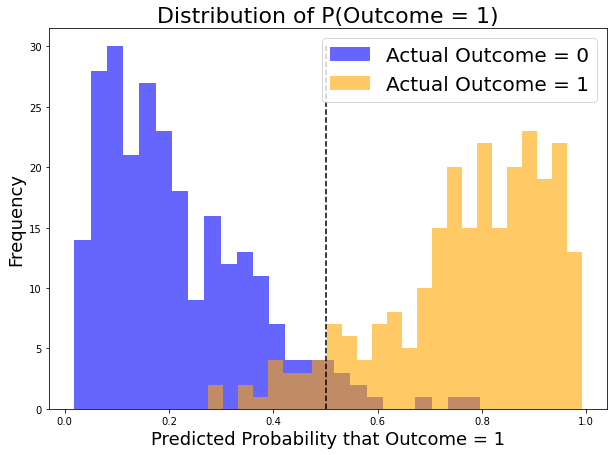

In [61]:
pred_df = pd.DataFrame({'true_values': nb_preds['Actual'],
                        'pred_probs':nb_preds['Predict_Proba']})
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Actual Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Actual Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
          ymin=0,
          ymax=30,
          color='black',
          linestyle = '--')


# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

We can see that once again, there are more science posts that are misclassified. However, as compared to logistic regression, we see that the outliers for the misclassfied history posts lie closer to 1. This is where the logistic regression performs better as the errors are more centered around 0.5.

However, the Naive Bayes model performs better in that the data that has been classified correctly is fatter at both ends - meaning clearer classification.

In [62]:
# Look at the misclassified science posts
nb_preds.loc[nb_preds['Correct'] == 1]

,Actual,Predicted,Predict_Proba,Text,Correct
581,1,0,0.354344,possible silverweed argentina anserina native across different continent evolved different specie different continent looking silverweed wikipedia entry say native throughout temperate northern hemisphere website seemed confirm considered native part north america europe even eurasia surprising usually expect different native specie family plant na v europe various kind maple tree silverweed specie continent,1
1413,1,0,0.491205,leading theory caused earthquake plate tectonics since plate tectonics relatively new validated leading theory caused earthquake since new guess must wild theory specially late xix early xx century period,1
1827,1,0,0.289440,earth annular lake north th parallel earth land surface wikipedia list annular lake north th parallel follow three country canada finland sweden make country prone annular lake others account majority land north th,1
554,1,0,0.464317,last earth land area evenly divided two hemisphere read recently cartographer antiquity believed yet undiscovered landmass southern hemisphere must balance northern hemisphere term area obviously untrue today last earth actually case,1
1964,1,0,0.416407,aquifer underground lake river title pretty much said always thought underground lake got thinking recently maybe river reading curious granite sand gravel aquifer regard,1
1195,1,0,0.484908,risotto turn better add broth slowly rather,1
1350,1,0,0.405218,classical music playing robot insult close ai replicating human performance research done topic good piano instrument playing ai,1
244,1,0,0.403898,finer detail jincan poison recently learned jincan poison got googled say last survivor get eaten larva never specified larva specie jincan fatal symptom considering ancient chinese poison using wild life native south east china possible replicate method venomous arthropod animal used process,1
1311,1,0,0.420126,stop diverting river replenish aral sea something bugged aral sea since learned soviet understand water still used agriculture kazakstan uzbekistan devastation losing th largest lake world seem outweigh missing something global disruptive tech challenge restoring landscape aral sea region april none discussed even partially returning river,1
1138,1,0,0.355659,discover supervolcano yellowstone writing bit alternate find answer everywhere easily looked talk previous eruption happened want scientist discovered supervolcano yellowstone,1


Once again, similar to our misclassified posts from the logistic regression, we see that the main culprit is topics surrounding geography. We should also note the number of posts that contain words below the mean word count. As for the lowest scoring one in line 583, we see that it has the word 'modern' and 'period', both of which relate to history, hence leading to this outlier.

We now move on to look at the misclassified history posts.

In [63]:
# Look at the misclassified science posts
nb_preds.loc[nb_preds['Correct'] == -1]

,Actual,Predicted,Predict_Proba,Text,Correct
1994,0,1,0.527057,many doctor professional knew tuskeegee syphilis experiment dr irwin shatz read article medical journal wrote outraged letter study author big journal study published repeatedly edit running point whistleblower came forward degree common knowledge amongst medical professional edit schatz shatz,-1
1638,0,1,0.751572,happened mom produce enough milk formula formula mom enough milk wet nurse could pull milk various animal inquiring mom anywhere world,-1
942,0,1,0.572561,often lifeboat battleship cruiser compromised battle damage understand hit carrier far lifeboat around center deck well gunships close fight damaged enough deploy lifeboat lifeboat likely screwed,-1
548,0,1,0.500490,limit number ranking qing dynasty harem sorry phrased poorly understanding qing dynasty harem certain ranking system starting empress highest going second class attendant limited amount spot ranking unlimited amount ranking,-1
729,0,1,0.697293,domestication deer widespread example reindeer range overlap northern human population deer specie exist almost environment human found besides providing good amount meat fur deer provide unique resource form antler course reindeer prove least certain specie capable draught animal give,-1
1793,0,1,0.522993,pricing become ubiquitous understand basic psychology saying easier person justify spending rather pricing scheme become commonplace particular person industry started trend,-1
188,0,1,0.796917,concerned revealing earth position golden record voyager space probe given probe low speed often context discussion voyager space probe mention elaborate golden record included craft show position earth potential alien specie finding probe often mention opposed inclusion security ground elaborate given low speed probe au sun year later light year au nearest star several light year sun think probe position trajectory alone likely make easy discern came alien specie advanced enough able visit u concern added later fringe group similar thought large hadron collider destroy universe turned genuine concern anyone taken seriously,-1
805,0,1,0.564509,much extinct celtiberian language could possibly revived,-1
292,0,1,0.517410,circumcision start actually first thought something done motivation invented independently occasion,-1
1908,0,1,0.515892,electrical socket become standardized u,-1


Similar to our logistic regression, we once again see many technical terms used here which are science-related if taken out of context. The outlier in line 188 with a probabilityof 0.8 is also the same outlier identified before which contains many more scientific terms than history-related ones.

Overall, the naive bayes performed better than the logistic regression with fatter tails and also a higher score. One thing to note is that it had a larger degree of misclassifcation (misclassified posts were misclassfied to a larger extent).

### 5.3 K Nearest Neighbors
Lastly, we move on to looking at our third model, K Nearest Neighbors with TF-IDF Vectorizer.

In [64]:
# We now work with knn with TF-IDF Vectorizer
tvec = TfidfVectorizer(max_df = 0.9,
                      max_features = 8000,    # Anything beyond this number doesnt change
                      min_df = 2,
                      ngram_range = (1,3))

X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

knn = KNeighborsClassifier(n_neighbors = 30,
                          metric = 'minkowski')

knn.fit(X_train_tvec, y_train)

print(f'The model score is {knn.score(X_train_tvec, y_train)}')
print(f'The score for the test data is {knn.score(X_test_tvec, y_test)}')

The model score is 0.9406270847231488
The score for the test data is 0.94


The parameters are more or less the same for this model and the previous 2. The only difference is the metrics used for our knn classifer. We found that setting the n_neighbors to 30 was the sweet spot and k is considerably large given that we have quite a large training set.

The best distance metric to use is minkowski as it is the most suited for [multi-dimensional data](https://stats.stackexchange.com/questions/29627/euclidean-distance-is-usually-not-good-for-sparse-data-and-more-general-case). Both Euclidean and Manhatten distances are not favourable for multi-dimensional data. High dimensionality is usually associated with sparse data. But maybe it is even worse when the data is very sparse. Because then the distance of any two objects will likely be a quadratic mean of their lengths. Cosine distance is also another popular metric but Minkowski gave the best results.

We go on to look at the misclassfications.

In [65]:
# Look at misclassfied data

# Create a new dataframe
knn_preds = pd.DataFrame()

prob_1 = []
prob_0 = []

knn_preds['Actual'] = y_test
knn_preds['Predicted'] = knn.predict(X_test_tvec).tolist()
knn_preds['Predict_Proba'] = [i[1] for i in knn.predict_proba(X_test_tvec)]
knn_preds['Text'] = X_test
knn_preds['Correct'] = knn_preds['Actual'] - knn_preds['Predicted'] # If the value is 1, we misclassified a science post,
                                                                 # If the value is -1, we misclassified a hist post

# Look at number of misclassified posts
knn_preds['Correct'].value_counts()

 0    470
 1     19
-1     11
Name: Correct, dtype: int64

We see a similar level of misclassifcation as compared to the previous 2 models. This is expected as test scores are roughly the same. Let's now look at it visually.

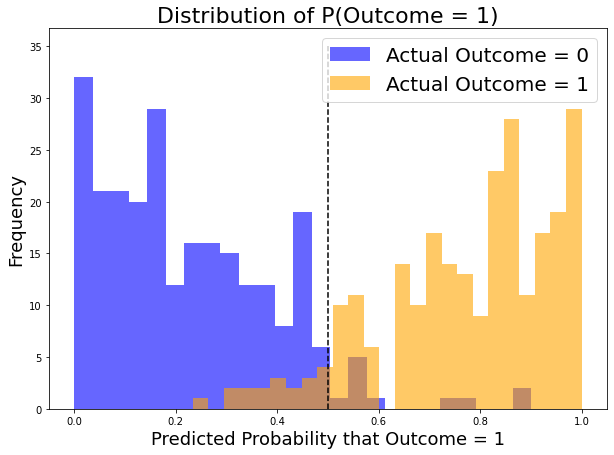

In [66]:
pred_df = pd.DataFrame({'true_values': knn_preds['Actual'],
                        'pred_probs':knn_preds['Predict_Proba']})
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Actual Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Actual Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
          ymin=0,
          ymax=35,
          color='black',
          linestyle = '--')


# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

We can see that this model too has fatter tails but also a very high magnitude of misclassifciation. We cna clearly spot some outliers in the data. Let us take a closer look at these misclassfied observations.

In [67]:
# Look at the misclassified science posts
knn_preds.loc[knn_preds['Correct'] == 1]

,Actual,Predicted,Predict_Proba,Text,Correct
940,1,0,0.400000,urethra sting sometimes urinate ejaculation,1
581,1,0,0.466667,possible silverweed argentina anserina native across different continent evolved different specie different continent looking silverweed wikipedia entry say native throughout temperate northern hemisphere website seemed confirm considered native part north america europe even eurasia surprising usually expect different native specie family plant na v europe various kind maple tree silverweed specie continent,1
444,1,0,0.500000,earthquake frequent along boundary pacific tectonic plate relative plate boundary specifically looking usgs map recent earthquake currentfeatureid u e uv extent extent sort largest listonlyshown true noticed earthquake occur around boundary pacific plate make pacific plate different plate,1
1413,1,0,0.500000,leading theory caused earthquake plate tectonics since plate tectonics relatively new validated leading theory caused earthquake since new guess must wild theory specially late xix early xx century period,1
882,1,0,0.466667,piezoelectric element mechanical force pulsed constantly applied saw video guy heating resistor pressing piezoelectric element clamp remained hot awhile,1
1827,1,0,0.366667,earth annular lake north th parallel earth land surface wikipedia list annular lake north th parallel follow three country canada finland sweden make country prone annular lake others account majority land north th,1
1964,1,0,0.500000,aquifer underground lake river title pretty much said always thought underground lake got thinking recently maybe river reading curious granite sand gravel aquifer regard,1
1195,1,0,0.466667,risotto turn better add broth slowly rather,1
860,1,0,0.300000,manage diabetes modern medicine,1
1350,1,0,0.333333,classical music playing robot insult close ai replicating human performance research done topic good piano instrument playing ai,1


Similar to the posts above, geographical words lead to misclassifcation. The outlier in line 1352 contains little words and contains words such as 'fatality', commonly discussed in history and also 'united states' wand one of our top words for history from the logstic regression was 'american.

In [68]:
# Look at the misclassified hist posts
knn_preds.loc[knn_preds['Correct'] == -1]

,Actual,Predicted,Predict_Proba,Text,Correct
1994,0,1,0.566667,many doctor professional knew tuskeegee syphilis experiment dr irwin shatz read article medical journal wrote outraged letter study author big journal study published repeatedly edit running point whistleblower came forward degree common knowledge amongst medical professional edit schatz shatz,-1
1638,0,1,0.766667,happened mom produce enough milk formula formula mom enough milk wet nurse could pull milk various animal inquiring mom anywhere world,-1
684,0,1,0.566667,precolonial disease spreadingwe always hear disease brought european settler america wiped swath indigenous population understanding european went back europe treasure animal literal america trade definitely carried form uncontacted virus disease etc counter spreading disease caused movement population heavily afflicted european population,-1
1034,0,1,0.533333,paul revere certify lesser silver work hi good r interested paul revere silversmith someone tell please went signing authenticating piece inscribe every piece made even modest piece nutmeg shaker spoon similar small piece likely signature imprimatur similar,-1
729,0,1,0.866667,domestication deer widespread example reindeer range overlap northern human population deer specie exist almost environment human found besides providing good amount meat fur deer provide unique resource form antler course reindeer prove least certain specie capable draught animal give,-1
1793,0,1,0.566667,pricing become ubiquitous understand basic psychology saying easier person justify spending rather pricing scheme become commonplace particular person industry started trend,-1
188,0,1,0.900000,concerned revealing earth position golden record voyager space probe given probe low speed often context discussion voyager space probe mention elaborate golden record included craft show position earth potential alien specie finding probe often mention opposed inclusion security ground elaborate given low speed probe au sun year later light year au nearest star several light year sun think probe position trajectory alone likely make easy discern came alien specie advanced enough able visit u concern added later fringe group similar thought large hadron collider destroy universe turned genuine concern anyone taken seriously,-1
805,0,1,0.566667,much extinct celtiberian language could possibly revived,-1
1188,0,1,0.566667,origin infinity heart symbol infinity heart symbol red blue generally polyamory symbol see without color christian symbol tell meaning either infinite love jesus infinite love person came first particular symbol anyone anything symbol started meaning group take another independently generated,-1
950,0,1,0.600000,ethnic difference celtiberians celt,-1


Once again, we see the same few culprits. The largest outlier is line 188 again and the addition of another one on line 729. Line 729 contains words such as 'environment', 'range', 'overlap', 'amount', 'resource', 'example', all of which are easily misclassified to belonging to science.

## <a name="sec_6"></a>Section 6: Findings

In this section we go on to summarise what we have explored in section 5 and answer our original data science problem.

### Our original problem
The problem we are seeking to answer is whether or not we can build a classfication model to accurately predict if a post belongs to one subreddit or the other. Should we be able to, we take a closer look at which model(s) serves this purpose the best and why.

We have shown that we are indeed able to build a model that can help us with our problem at hand and has an accuracy of ~94% in classifying unseen data. This then begs the question, which model should we use?

### The 'best' model
There is no clear answer for this and this depends on what we are seeking to achieve.

The first step is clear, the TF-IDF vectorizer is the vectorizer of choice across all our models. This vectorizer helps us tease out relevance of words instead of simply just the count of words. If we are unable to clearly pre-process our data, this is even more helpful. Even if we can pre-process our data and clean it to a considerable extent, the TF-IDF vectorizer still serves us well. It even helps us 'scale' the data to fit into models such as K Nearest Neighbors where normal standard scaling will prove to be a challenge. Count vectorizer suffers from the following shortfalls:
* Its inability in identifying more important and less important words for analysis.
* It will just consider words that are abundant in a corpus as the most statistically significant word.
* It also doesn't identify the relationships between words such as linguistic similarity between words.

**It is clear that TF-IDF vectorizer is the pre-processor for our data**

Next, what classification model should we use? 

If we are purely concerned with the highest accuracy then the Naive Bayes model is the go-to model of choice. However, if we are looking for a healthy balance between bias-variance, the K Nearest Neighbors model showed the smallest degree of overfitting as compared to the other 2 models. The logistic regression overfitted by 6.13%, the naive bayes overfitted by 5.60% but the K Nearest Neighbors Classifier overfitted by only 2.6%.

Does this mean that the logistic regression is redundant? Hardly so. The logistic regression performed the worst most possibly due to the fact that we had a relatively small training set. In a [paper written by Professor Andrew Ng and Professor Michael I Jordan](http://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf), it provided a mathematical proof of error properties of both the logistic regression and naive bayes. They concluded that when the training size reaches infinity, the discriminative model: logistic regression performs better than the generative model (naive bayes). 

Generative classifiers learn a model of the joint probability of the inpputs (x) and the label (y) and make their predictions using Bayes rules to calculate the probability of y given x and then picking the most likely label y. Discriminative classifiers model the posterior probability of y given x directly, or learn a direct map from inputs x to the class labels. One of the compelling reasons for using a logistic regression over naive bayes as articulated by Vapnik is that one should solve the classification problem directly and never a more general problem as an intermediate step (such as modelling probability of x given y).

The generative model (Naive Bayes) reaches the asymptotic solution for fewer training sets than the discriminative model (Logistic Regression). This behavior is best represented by the experiment conducted by Ng & Jordan where they did predictions for 15 datasets from the UCI machine learning repository. In some cases the training sample was not large enough for logistic regression to win.

In mathematical analysis, asymptotic analysis, also known as asymptotics, is a method of describing limiting behavior. In mathematical statistics and probability theory, asymptotics are used in analysis of long-run or large-sample behaviour of random variables and estimators.

In short Naive Bayes has a higher bias but lower variance compared to logistic regression. If the data set follows the bias then Naive Bayes will be a better classifier. Both Naive Bayes and Logistic regression are linear classifiers, Logistic Regression makes a prediction for the probability using a direct functional form where as Naive Bayes figures out how the data was generated given the results.

It is clear now when we should use logistic regression or naive bayes, what about K Nearest Neighbors? As mentionted above, it was the model that showed the lowest degree of overfitting. However, the model was successful likely due to the extent of our pre-processing and how we were able to effectively remove irrelevant words. In a [paper](https://core.ac.uk/download/pdf/82438337.pdf) by Bruno Trstenjak, Sasa Mikac and Dzenana Donko in the 69th edition of Procedia Engineering, they did an in-depth study on KNN with TF-IDF Based Framework for Text Categorization. The framework they presented gave good results and confirmed their initial expectations that the model would be effective 

However, tests have shown that the embedded algorithm is sensitive to the type of dicuments. They classified text documents into Sport, Politics, Finance and Daily News. Sport showed the highest accuracy of 0.92, followed by Politics with 0.90, Finance with 0.78 and Daily News with 0.65. This was due to the fact that the document contents in the category Daily News contained a lot of 'unusable words', words that are often repeated and do not have important weight but have an adverse impact on KNN. The analysis of documents showed that the amount of unusable words in documents has a significant impact on the final quality of classification. because of this, it is important to improve the preprocessing of data for better results.

Given that this is a lot of information to take in, we present a simple flowchart that serves as a guide to think about what the appropriate model to use is.

<img src="./images/flowchart.jpg">

### Future steps
A potetial improvement for the project would be to examine the models with larger datasets. This can truly test the assumption that as training datasets grow, logistic regressions will perform better.

Another improvement will be to use more similar categories to really put our pre-processing to the test. We have been quite fortunate to deal with technical topics with many 'usable' words. Should we be able to work on more generic categories, we can potentially test to see if K Nearest Neighbors still performs well and to what extent pre-processing can improve our results.